# Implementation Exercise: Work in Progress
### _Return Predictability and Dynamic Asset Allocation: How Often Should Investors Rebalance?_
by _Himanshu Almadi, David E. Rapach, and Anil Suri_

## 1. Processing data from Bloomberg Terminal

In [528]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing
from cvxopt import matrix, solvers

In [2]:
def process_xlsx(filename,filetype = 'Bloomberg'):
    """
    process .xlsx files downloaded from Bloomberg and Factset
    """
    if filetype == 'Bloomberg':
        df = pd.read_excel(filename,header=5)
        df.rename(columns = {'Unnamed: 0':'dates'},inplace=True)
        df.loc[:,'Dates']=pd.to_datetime(df['Dates'])
    if filetype == 'Bonds':
        df = pd.read_excel(filename,header=3,parser='Date')
    if filetype == 'Bills':
        df = pd.read_excel(filename,header=20,parser='Date')
    return df.reset_index(drop=True)

In [3]:
other_df = process_xlsx('others.xlsx')
other_df.head()

,Dates,SPX Index,SPXDIV Index,CPI INDX Index,CT10 Govt,CB3 Govt,MOODCBAA Index,MOODCAAA Index,IP Index
0,NaT,329.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1990-02-28,331.89,NaN,128.0,NaN,NaN,10.14,9.22,64.0446
2,1990-03-30,339.94,0.31,128.6,NaN,NaN,10.21,9.37,64.3580
3,1990-04-30,330.80,0.98,128.9,NaN,NaN,10.30,9.46,64.2602
4,1990-05-31,361.23,2.74,129.1,NaN,NaN,10.41,9.47,64.3973


In [4]:
df_bonds = process_xlsx('./facset/US10YY-TU1.xlsx','Bonds')
df_bonds.head()

,Date,Close,Volume,Change,% Change,Total Return (Gross),Cumulative Return %,Open,High,Low
0,1990-01-31,8.43,NaN,NaN,NaN,8.43,0.000000,NaN,NaN,NaN
1,1990-02-28,8.51,NaN,0.080000,0.948991,8.51,0.948992,NaN,NaN,NaN
2,1990-03-30,8.65,NaN,0.139999,1.645116,8.65,2.609727,NaN,NaN,NaN
3,1990-04-30,9.04,NaN,0.390000,4.508675,9.04,7.236062,NaN,NaN,NaN
4,1990-05-31,8.60,NaN,-0.440000,-4.867252,8.60,2.016607,NaN,NaN,NaN


In [5]:
df_bill = process_xlsx('./facset/TRYUS3M-FDS.xlsx','Bills')
df_bill.head()

,Date,Close,Volume,Change,% Change,Total Return (Gross),Cumulative Return %,Open,High,Low
0,1990-01-31,7.74,NaN,NaN,NaN,7.74,0.000000,NaN,NaN,NaN
1,1990-02-28,7.77,NaN,0.03,0.387600,7.77,0.387597,NaN,NaN,NaN
2,1990-03-30,7.80,NaN,0.03,0.386103,7.80,0.775194,NaN,NaN,NaN
3,1990-04-30,7.79,NaN,-0.01,-0.128208,7.79,0.645995,NaN,NaN,NaN
4,1990-05-31,7.75,NaN,-0.04,-0.513478,7.75,0.129199,NaN,NaN,NaN


## 2. Processing Explanatory Variables

### 2.1 log(D/P)

More specifically, I am computing the following:
$$ log(\sum_{s=1}^{12} D_{t-(s-1)}) - log(P_{t}) $$
where `D` stands for dividens paid by `SP500` constituents at time t. 
And `P` stands for `SP500` at time t.


As a sanity check, I wanted to check there are only two `NaN` values for `SPXDIV Index`

In [6]:
other_df['SPXDIV Index'].isna().sum()

2

In [7]:
other_df.head()

,Dates,SPX Index,SPXDIV Index,CPI INDX Index,CT10 Govt,CB3 Govt,MOODCBAA Index,MOODCAAA Index,IP Index
0,NaT,329.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1990-02-28,331.89,NaN,128.0,NaN,NaN,10.14,9.22,64.0446
2,1990-03-30,339.94,0.31,128.6,NaN,NaN,10.21,9.37,64.3580
3,1990-04-30,330.80,0.98,128.9,NaN,NaN,10.30,9.46,64.2602
4,1990-05-31,361.23,2.74,129.1,NaN,NaN,10.41,9.47,64.3973


In [8]:
df = pd.DataFrame([])
df['Dates'] = other_df['Dates']
df['log_DP'] = (other_df['SPXDIV Index'].rolling(12).sum().apply('log').shift()
                - other_df['SPX Index'].apply('log'))

In [9]:
df[['Dates','log_DP']][13:].head()

,Dates,log_DP
13,1991-02-28,NaN
14,1991-03-29,-3.184739
15,1991-04-30,-3.187664
16,1991-05-31,-3.221650
17,1991-06-28,-3.175793


Compare 14th row with following for sanity check:

In [10]:
np.log(sum(other_df['SPXDIV Index'][2:14])) - np.log(other_df['SPX Index'][14])

-3.1847388834548687

### 2.2 Inflation

Inflation is calculated by CPI Index. The research paper writes following: 
<br>
_We account for the delay in the release of monthly CPI data when computing the forecast_
<br>
My susequent search suggested that  CPI Index is released with lag of 1 month.
<br>
Thus, I adjust for the issue by shifting CPI Index level by 1.
$$ inflation_{t} = \frac{CPI_{t}}{CPI_{t-1}}$$
However, at time t, the most recent available inflation rate is that of time t-1.


In [11]:
df['inflation'] = other_df['CPI INDX Index'].pct_change().shift()

In [12]:
df[['Dates','inflation']].head()

,Dates,inflation
0,NaT,NaN
1,1990-02-28,NaN
2,1990-03-30,NaN
3,1990-04-30,0.004687
4,1990-05-31,0.002333


Following is a sanity check. inflation rate for 2nd row is consistent with third row of inflation columns. The rationale for this is explained at the Markdown Cell above

In [13]:
(other_df['CPI INDX Index'][2]/other_df['CPI INDX Index'][1] -1)

0.004687499999999956

### 2.3 Term Spread

Term spread refers to the difference between 10-year Treasury bond yield and the three-month Treasury bill yield.


In [14]:
df['Term_Spread'] = df_bonds['Close'] - df_bill['Close']

In [15]:
df[['Dates','Term_Spread']].head()

,Dates,Term_Spread
0,NaT,0.690001
1,1990-02-28,0.740000
2,1990-03-30,0.849999
3,1990-04-30,1.250000
4,1990-05-31,0.850000


### 2.4 Default Spread

The difference between Moody's BAA and AAA rated corporate Bond yields

In [16]:
df['Default_Spread']=other_df['MOODCBAA Index'] - other_df['MOODCAAA Index']

In [17]:
df[['Dates','Default_Spread']].head()

,Dates,Default_Spread
0,NaT,NaN
1,1990-02-28,0.92
2,1990-03-30,0.84
3,1990-04-30,0.84
4,1990-05-31,0.94


As with `term spread`, a few observation would be sufficient for a sanity check as it only requires a subtraction

In [18]:
other_df[['Dates','MOODCBAA Index','MOODCAAA Index']].head()

,Dates,MOODCBAA Index,MOODCAAA Index
0,NaT,NaN,NaN
1,1990-02-28,10.14,9.22
2,1990-03-30,10.21,9.37
3,1990-04-30,10.30,9.46
4,1990-05-31,10.41,9.47


### 2.5  Moving Averages

Average of `SPX Index` for the past 12-months.
<br>
$$ MA_{t} = \frac{\sum_{i=0}^{11} SPX_{t-i}}{12}$$

In [19]:
Moving_Average_12 = other_df['SPX Index'].rolling(12).mean()

In [20]:
Moving_Average_12[10:].head()

10           NaN
11    332.680000
12    333.917500
13    336.849167
14    339.789167
Name: SPX Index, dtype: float64

As a sanity check: the moving average of first 12 numbers are as following:

In [21]:
np.mean(other_df['SPX Index'][:12])

332.68000000000006

In [22]:
Moving_Average_2 = other_df['SPX Index'].rolling(2).mean()

In [23]:
Moving_Average_2.head()

0        NaN
1    330.485
2    335.915
3    335.370
4    346.015
Name: SPX Index, dtype: float64

As a sanity check: the moving average of first 12 numbers are as following:

In [24]:
np.mean(other_df['SPX Index'][:2])

330.485

In [25]:
Bond_Moving_Average_12 = df_bonds['Close'].rolling(12).mean()

In [26]:
Bond_Moving_Average_12[10:].head()

10         NaN
11    8.557500
12    8.524167
13    8.483333
14    8.433333
Name: Close, dtype: float64

As a sanity check: the moving average of first 12 numbers are as following:

In [27]:
df_bonds['Close'][:12].mean()

8.557499965031942

In [28]:
Bond_Moving_Average_6 = Bond_Moving_Average_12 = df_bonds['Close'].rolling(6).mean()

In [29]:
Bond_Moving_Average_6[5:].head()

5    8.610000
6    8.598333
7    8.656667
8    8.685000
9    8.620000
Name: Close, dtype: float64

In [30]:
np.mean(df_bonds['Close'][:6])

8.610000133514404

### 2.5.1 MA(1,12) 

It is a dummy variable based on `SPX Index` level and `Moving_Average_12`
<br>
If `SPX Index` value is greater than its 12 months moving average, then assign 1. Otherwise assign 0.

In [31]:
MA_nan = (other_df['SPX Index']-Moving_Average_12).apply(lambda x: np.nan if np.isnan(x) else 0)

In [32]:
df['MA_1_12']=(other_df['SPX Index']-Moving_Average_12).apply(lambda x: 1 if x>0 else 0) + MA_nan

In [33]:
df[['Dates','MA_1_12']][9:].head()

,Dates,MA_1_12
9,1990-10-31,NaN
10,1990-11-30,NaN
11,1990-12-31,0.0
12,1991-01-31,1.0
13,1991-02-28,1.0


As a sanity check, since Moving_Average_12 is already checked, following shows that lambda function performs as expected.

In [34]:
(other_df['SPX Index']-Moving_Average_12)[9:].head()

9           NaN
10          NaN
11    -2.460000
12    10.012500
13    30.220833
Name: SPX Index, dtype: float64

### 2.5.2 MA(2,12) 

It is a dummy variable based on `Moving_Average_2`  and `Moving_Average_12`
<br>
If `Moving_Average_2` value is greater than `Moving_Average_12` value, then assign 1. Otherwise assign 0.

In [35]:
df['MA_2_12']=(Moving_Average_2-Moving_Average_12).apply(lambda x: 1 if x>0 else 0) + MA_nan

In [36]:
df[['Dates','MA_2_12']][9:].head()

,Dates,MA_2_12
9,1990-10-31,NaN
10,1990-11-30,NaN
11,1990-12-31,0.0
12,1991-01-31,1.0
13,1991-02-28,1.0


### 2.5.3 MOMBY(6) 

It is a dummy variable based on `Bond_Moving_Average_6`  and the current bond yield.
<br>
If the bond yield is greater than `Bond_Moving_Average_6` by more than 5 basis points, assign -1. 
<br>
Else if the bond yield is less than `Bond_Moving_Average_6` by more than 5 basis points, assign 1.
<br>
Otherwie, assign 0.

In [37]:
MOMBY_6_nan = (df_bonds['Close']-Bond_Moving_Average_6
              ).apply(lambda x: np.nan if np.isnan(x) else 0)

In [38]:
df['MOMBY_6']=(df_bonds['Close']-Bond_Moving_Average_6
              ).apply(lambda x: -1 if x>0.05 else (1 if x<0.05 else 0)) + MOMBY_6_nan

In [39]:
df[['Dates','MOMBY_6']][5:].head()

,Dates,MOMBY_6
5,1990-06-29,1.0
6,1990-07-31,1.0
7,1990-08-31,-1.0
8,1990-09-28,-1.0
9,1990-10-31,1.0


### 2.5.3 MOMBY(12) 

In [40]:
MOMBY_12_nan = (df_bonds['Close']-Bond_Moving_Average_12
              ).apply(lambda x: np.nan if np.isnan(x) else 0)

In [41]:
df['MOMBY_12']=(df_bonds['Close']-Bond_Moving_Average_12
              ).apply(lambda x: -1 if x>0.05 else (1 if x<0.05 else 0)) + MOMBY_12_nan

In [42]:
df[['Dates','MOMBY_12']][11:].head()

,Dates,MOMBY_12
11,1990-12-31,1.0
12,1991-01-31,1.0
13,1991-02-28,1.0
14,1991-03-29,1.0
15,1991-04-30,1.0


### 2.6 MOM

It is a dummy variable that depends on `SPX Index` and its lagged values.

### 2.6.1 MOM(9)
If the difference between `SPX Index` and its 9 months lagged value is positive then assign 1. Otherwise assign 0.

In [43]:
MOM_9_nan = (other_df['SPX Index']-other_df['SPX Index'].shift(9)
            ).apply(lambda x: np.nan if np.isnan(x) else 0)
df['MOM_9']=(other_df['SPX Index']-other_df['SPX Index'].shift(9)
            ).apply(lambda x: 1 if x>0 else 0) + MOM_9_nan

In [44]:
df[['Dates','MOM_9']][8:].head()

,Dates,MOM_9
8,1990-09-28,NaN
9,1990-10-31,0.0
10,1990-11-30,0.0
11,1990-12-31,0.0
12,1991-01-31,1.0


Following checks the result

In [45]:
(other_df['SPX Index']-other_df['SPX Index'].shift(9))[8:].head()

8       NaN
9    -25.08
10    -9.67
11    -9.72
12    13.13
Name: SPX Index, dtype: float64

### 2.6.2 MOM(12)
If the difference between `SPX Index` and its 12 months lagged value is positive then assign 1. Otherwise assign 0.

In [46]:
MOM_12_nan = (other_df['SPX Index']-other_df['SPX Index'].shift(12)
            ).apply(lambda x: np.nan if np.isnan(x) else 0)
df['MOM_12']=(other_df['SPX Index']-other_df['SPX Index'].shift(12)
            ).apply(lambda x: 1 if x>0 else 0) + MOM_12_nan

In [47]:
df[['Dates','MOM_12']][11:].head()

,Dates,MOM_12
11,1990-12-31,NaN
12,1991-01-31,1.0
13,1991-02-28,1.0
14,1991-03-29,1.0
15,1991-04-30,1.0


### 2.7 Output Gap

The deviation of the log of industrial production from a quadratic trend.
<br>
I believe this data is available from Bloomberg Terminal. 
However, it is simple to compute. Therefore, I decided to simply compute it.
<br>
A quadratic trend is of the following form:
<br>
$$ y_{t} = \beta_{0} + \beta_{0}x_{t} + \beta_{0}x_{t}^2 +\epsilon_{t} $$
<br>
$\widehat{\beta}$ is estimated by $$\widehat{\beta} = (X^{T}X)^{-1}X^{T}y  $$

following provides an illustration of this estimation procedure.



In [48]:
def beta_est(obs):
    """
    estimates beta of ols to minimize l2 norm
    """
    y = np.log(other_df['IP Index'].dropna())[:obs]
    X = np.concatenate((np.ones(obs).reshape(-1,1),np.arange(obs).reshape(-1,1)),axis=1)
    X = np.concatenate((X,(np.arange(obs)**2).reshape(-1,1)),axis=1)
    beta_hat = np.dot(np.matmul(np.linalg.inv(1e-6 *np.eye(3) + np.matmul(X.transpose(),X)),
                                X.transpose()),y.values.reshape(-1,1))
    return beta_hat

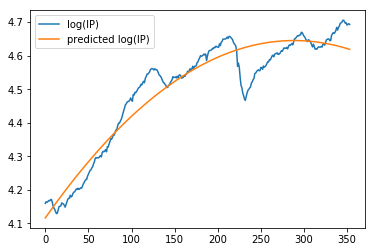

In [49]:
n = len(np.log(other_df['IP Index'].dropna()))
X = np.concatenate((np.ones(n).reshape(-1,1),np.arange(n).reshape(-1,1)),axis=1)
X = np.concatenate((X,(np.arange(n)**2).reshape(-1,1)),axis=1)
beta_hat = beta_est(n)
y_pred = np.matmul(X,beta_hat)
y = np.log(other_df['IP Index'].dropna())
plot_df = np.concatenate((np.arange(n).reshape(-1,1),y.values.reshape(-1,1),y_pred),axis=1)
plot_df = pd.DataFrame(plot_df)
plot_df.columns = ['obs','log(IP)','predicted log(IP)']
plt.plot('obs','log(IP)',data=plot_df)
plt.plot('obs','predicted log(IP)',data=plot_df)
plt.legend()

However, the research estimates $\widehat{\beta}$ from data available up to each point in time. Thus, I will repeat the calculation above to every time step.

In [50]:
def output_gap_computer(obs):
    """
    computes the deviation of the log of industrial production from a quadratic trend.
    """
    return y[obs]-np.dot(X[:obs],beta_est(obs))[-1]

In [51]:
# Next Cell parallelize for loop. It is equivalent to

# output_gap2 = []
# for i in range(1,n+1):
#     output_gap2 += [output_gap_computer(i)]

In [52]:
pool = multiprocessing.Pool(4)
output_gap =[*pool.map(output_gap_computer, range(1, n+1))]

In [53]:
df['output_gap']=np.concatenate(([np.nan],np.array(output_gap).reshape(-1)))

In [54]:
df[['Dates','output_gap']].head()

,Dates,output_gap
0,NaT,NaN
1,1990-02-28,4.159576e-06
2,1990-03-30,2.422823e-09
3,1990-04-30,-5.646037e-09
4,1990-05-31,5.029228e-04


### 2.7 SPX Index return


In [55]:
df['r_SPX'] = other_df['SPX Index'].pct_change()
df[['Dates','r_SPX']].head()

,Dates,r_SPX
0,NaT,NaN
1,1990-02-28,0.008539
2,1990-03-30,0.024255
3,1990-04-30,-0.026887
4,1990-05-31,0.091989


### 2.8 Bond return and yield

In [141]:
def compound_return(cum_return):
    sol = (cum_return.values/100 + 1)
    for i in range(2,len(sol)):
       sol[i] = sol[i]/(cum_return.values/100 + 1)[i-1]
    return sol - 1


In [142]:
df['y_bond'] = df_bonds['Close']/100
df[['Dates','y_bond']].head()

,Dates,y_bond
0,NaT,0.0843
1,1990-02-28,0.0851
2,1990-03-30,0.0865
3,1990-04-30,0.0904
4,1990-05-31,0.0860


In [143]:
df['r_bond'] = compound_return(df_bonds['Cumulative Return %'])
df[['Dates','r_bond']].head()

,Dates,r_bond
0,NaT,0.000000
1,1990-02-28,0.009490
2,1990-03-30,0.016451
3,1990-04-30,0.045087
4,1990-05-31,-0.048673


To check the compound_return function indeed takes cumulative return as input and computes the compounding rate of return: I will manually compute `r_bond` on `1990-03-30`. The numbers correspond to cumulative returns as can be seen from the cell below:
<br>
$$ (1.026097) = (1.009490)(1 + r) \Rightarrow r = 0.016451$$
$$ (1.072361) = (1.009490)(1.016451)(1 + r) \Rightarrow r = 0.045087 $$



In [144]:
(df_bonds['Cumulative Return %']/100 + 1).head()

0    1.000000
1    1.009490
2    1.026097
3    1.072361
4    1.020166
Name: Cumulative Return %, dtype: float64

### 2. Bill return and yield

In [145]:
df['y_bill'] = df_bill['Close']/100
df[['Dates','y_bill']].head()

,Dates,y_bill
0,NaT,0.0774
1,1990-02-28,0.0777
2,1990-03-30,0.0780
3,1990-04-30,0.0779
4,1990-05-31,0.0775


,Dates,r_bill
0,NaT,0.000000
1,1990-02-28,0.003876
2,1990-03-30,0.003861
3,1990-04-30,-0.001282
4,1990-05-31,-0.005135


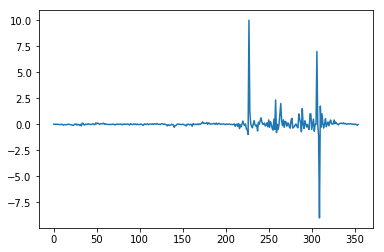

In [147]:
df['r_bill'] = compound_return(df_bill['Cumulative Return %'])
plt.plot(df['r_bill'])
df[['Dates','r_bill']].head()

To check the compound_return function indeed takes cumulative return as input and computes the compounding rate of return: I will manually compute `r_bill` on `1990-03-30`. The numbers correspond to cumulative returns as can be seen from the cell below:
<br>
$$ (1+ 0.007752) = (1 + 0.003876)(1 + r) \Rightarrow r = 0.003861$$
$$ (1 + 0.006460) = (1 + 0.003876)(1 + 0.003861)(1 + r) \Rightarrow r = -0.001282 $$



In [62]:
(df_bill['Cumulative Return %']/100 + 1).head()

0    1.000000
1    1.003876
2    1.007752
3    1.006460
4    1.001292
Name: Cumulative Return %, dtype: float64

In [140]:
1.006460/((1+0.003861)*(1+0.003876)) -1

-0.001282027007208475

## 3. Return Forecasts

After preprocessing available data is from 1991-03-29 to 2019-07-31

In [63]:
processed_df = df.loc[14:].reset_index(drop=True)
processed_df.head()

,Dates,log_DP,inflation,Term_Spread,Default_Spread,MA_1_12,MA_2_12,MOMBY_6,MOMBY_12,MOM_9,MOM_12,output_gap,r_SPX,y_bond,r_bond,y_bill,r_bill
0,1991-03-29,-3.184739,0.000742,2.31,1.16,1.0,1.0,1.0,1.0,1.0,1.0,0.003305,0.022203,0.0805,0.003741,0.0574,-0.049669
1,1991-04-30,-3.187664,0.000000,2.51,1.08,1.0,1.0,1.0,1.0,1.0,1.0,0.008409,0.000346,0.0802,-0.003727,0.0551,-0.040070
2,1991-05-31,-3.221650,0.002226,2.53,1.00,1.0,1.0,1.0,1.0,1.0,1.0,0.015507,0.038577,0.0806,0.004988,0.0553,0.003630
3,1991-06-28,-3.175793,0.003701,2.70,0.95,1.0,1.0,-1.0,-1.0,1.0,1.0,0.018247,-0.047893,0.0824,0.022333,0.0554,0.001808
4,1991-07-31,-3.222907,0.002950,2.67,0.89,1.0,1.0,-1.0,-1.0,1.0,1.0,0.014082,0.044859,0.0820,-0.004854,0.0553,-0.001805


### 3.1 Stock Returns

First step is to find truncated PCA for different number of eigenvalues.
<br>
PCA is implemented on the following matrix. Each variable corresponds to a set of observations and hence is a column vector.
<br>
[ $log(\frac{D}{P})$, Inflation, Term Spread, Default Spread, Output Gap, MA(1,12), MA(2,12), MOM(9), MOM(12) ] 
<br>

Second step is to come up with a decision rule on how to truncate eigenvalues.
The research paper utilizes (1) out-of-sample $R^2$ denoted as $R_{OS}^2$ and (2) Clark and West statistic.
<br>
where 
$$R_{OS}^2 = 1 - \frac{\sum_{t=1}^T (r_{t} - \widehat{r}_{t})}{\sum_{t=1}^T (r_{t} - \overline{r}_{t-1})} $$
and
<br>
<br>
$\widehat{r}_{t}$ is the fitted value using data up to t-1
<br>
$\overline{r}_{t-1}$ is the historal average using data upto t-1
<br>
<br>
Apart from $R_{OS}^2$, the paper utilizes Clark and West (2007) test. 
<br> Refer: Approximately Normal Tests for Equal Predictive Accuracy in Nested Models.
<br> Clark and West claims that test of mean squared prediction error (MSPE) typically exhibits a stylised pattern. That is, `the MSPE under Null (parsimonious model) is relatively smaller than it is expected to be because of the efficiency of parsimonious model and noises from estimating more parameters`. Therefore, authors propose an alternative hypothesis test as following:
<br>
For the hypothesis testing <br>H0: Parsimonious model (constant) MSPE is equal to or better than that of the larger model, H1: Larger model is better.
$$ \hat{f}_{t+1} = (y_{t+1} - \hat{y}_{\text{pars:} t,t+1})^2 - [(y_{t+1} - \hat{y}_{\text{large:} t,t+1})^2 - (\hat{y}_{\text{pars:} t,t+1} - \hat{y}_{\text{large:} t,t+1})^2] $$
$$ \overline{f} = \frac{1}{T}\sum_{t=1}^{T}\hat{f}_{t+1}$$
$$ s_{\hat{f}-\overline{f}}^2 = \frac{1}{T-1}\sum_{t=1}^{T}(\hat{f}_{t+1}-\overline{f})^2 $$

<br>Test statistics is: $$ CW = \frac{\overline{f}}{s_{\hat{f}-\overline{f}}/\sqrt{T}}$$ <br> the mean of $\hat{f}_{t+\tau}$ denoted as $\overline{\hat{f}_{t+\tau}}$ . With 10% significance level, reject null if $\overline{\hat{f}_{t+\tau}}$ > 1.282. With 5% significance level, reject null if $\overline{\hat{f}_{t+\tau}}$ > 1.645. For one step forecast errors, the usual least squares standard errors can be used. For autocorrelated forecast errors, an autocorrelation consistent standard error should be used.

In [64]:
def truncated_PC(X,dim):
    eig, V = np.linalg.eig(np.matmul(X.transpose(),X))
    approx_X =  np.matmul(X,V[:,:dim])
    return approx_X

In [65]:
def PC_approx_error(X,dim):
    """
    PC approximation errors in terms of frobenius norms
    """
    eig, V = np.linalg.eig(np.matmul(X.transpose(),X))
    approx_A =  np.matmul(np.matmul(V[:,:dim],
                            np.diag(eig[:dim])),
                            V[:,:dim].transpose())
    error = np.linalg.norm(approx_A - np.matmul(X.transpose(),X), ord='fro')
    return error

In [66]:
def PC_fit(X,r,dim):
    """
    estimates SPX Index return in a way that minimizes l2 norm
    """
    X = np.concatenate((np.ones(X.shape[0]).reshape(-1,1),X),axis=1)
    beta = \
    np.matmul(
        np.linalg.inv(1e-6*np.eye(dim+1) + np.matmul(X.transpose(),X)),
        np.matmul(X.transpose(),r))
    return beta

### 3.1.1 Principle Component Regression

In [67]:
stock_explanatory_variables = ['log_DP','inflation','Term_Spread','Default_Spread',\
                               'output_gap','MA_1_12','MA_2_12','MOM_9','MOM_12']
X = processed_df[stock_explanatory_variables].values

The plot of PC approximation errors in terms of frobenius norm is as following:

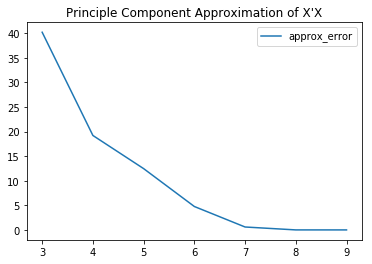

In [68]:
PC_plot_df = pd.DataFrame([])
PC_plot_df['dim'] = range(3,X.shape[1]+1) 
PC_plot_df['approx_error'] = [PC_approx_error(X,dim) for dim \
                               in range(3,X.shape[1]+1)]
plt.plot('dim','approx_error',data=PC_plot_df)
plt.title("Principle Component Approximation of X'X")
plt.legend()

Above plot confirms that the principle component approximation works as expected

Following figures compare actual return with estimated return based on PC regression.

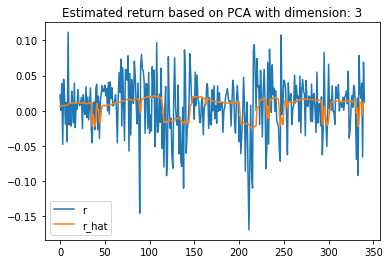

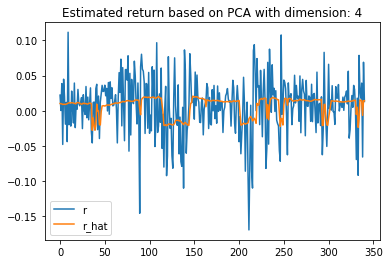

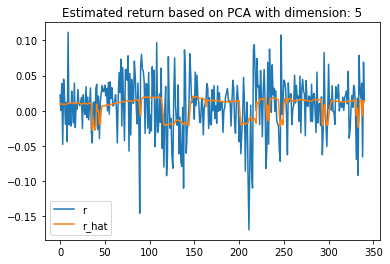

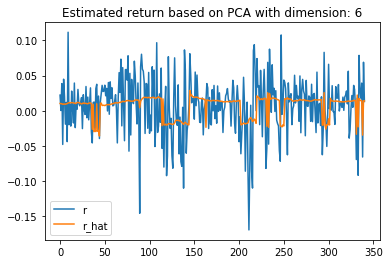

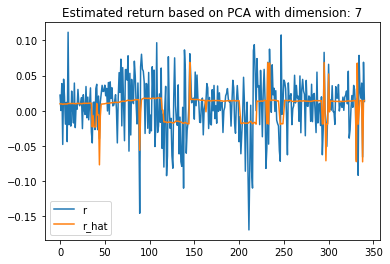

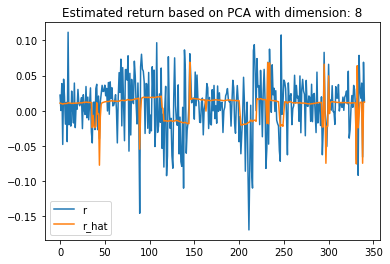

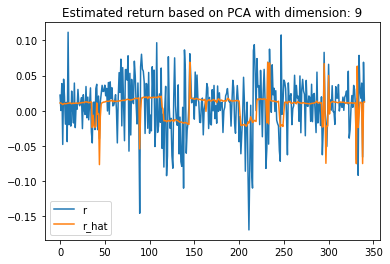

In [69]:
for i in range(3,10):
    dim = i
    r = processed_df['r_SPX'].values
    X_PCA = truncated_PC(X,dim)
    w = PC_fit(X_PCA,r,dim)
    X_PCA_intercept = np.concatenate((np.ones(X_PCA.shape[0]).reshape(-1,1),X_PCA),axis=1)
    r_hat = np.matmul(X_PCA_intercept,w)
    plt.figure(i)
    PC_plot_df2 = pd.DataFrame([])
    PC_plot_df2['r_hat'] = r_hat
    PC_plot_df2['r'] = r
    plt.plot('r',data=PC_plot_df2)
    plt.plot('r_hat',data=PC_plot_df2)
    plt.title(f'Estimated return based on PCA with dimension: {dim}')
    plt.legend()


### 3.1.2  $R_{OS}^2$ Computation

Following the logic of the original paper, I will compute $R_{OS}^2$ for monthly (h=1), quartherly (h=3), semi-annual (h=6), and annual (h=12). And out-of-sample forecasts are estimated by recursive estimation windows. For example, for monthly estimation, initial 200 samples are used exclusively for fitting the model. The 201$^{\text{st}}$ sample is forecasted by the model fitted by 200 samples. The 202$^{\text{nd}}$ sample is estimated by the model fitted using 201 samples. And so on.
<br>
<br>
Below illustrations show that monthly $R_{OS}^2$ gives the highest value range. This is consistent with the original paper. 

In [70]:
X[:200].shape

(200, 9)

In [71]:
def Rsquared_OS(X,r,dim,OS_start):
    """
    computes out-of-sample rsquared.
    First computes PCA only using explanatory variables without augmenting the data with a constant = 1.
    For regression result, added a constant to capture the y-intercept. 
    PCA_fit by default adds the constant column. Therefore, I only add the constant column to obtain
    one step ahead forecast using the weights obtained by the PCA_fit
    """
    numerator = 0
    denominator = 0
    for i in range(OS_start,len(r)):
        X_PCA = truncated_PC(X[:i],dim)
        w = PC_fit(X_PCA,r[:i],dim) 
        X_PCA_OS = truncated_PC(X[:i+1],dim)
        X_PCA_OS_intercept = np.concatenate((np.ones(X_PCA_OS.shape[0]).reshape(-1,1),X_PCA_OS),axis=1)
        r_hat = np.matmul(X_PCA_OS_intercept[-1],w)
        numerator += (r[i] - r_hat)**2
        denominator += (r[i]-r[:i].mean())**2
    R_squared_OS = 1 - numerator/(denominator + 1e-6)
    return R_squared_OS

### 3.1.2.1 Month $R_{OS}^2$ 

Text(0.5, 1.0, 'Month out-of-sample R-squared')

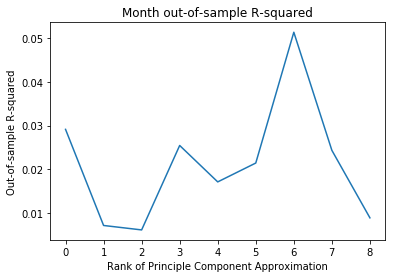

In [72]:
plt.plot([Rsquared_OS(X,r,i,200) for i in range(1,X.shape[1]+1)])
plt.xlabel('Rank of Principle Component Approximation')
plt.ylabel('Out-of-sample R-squared')
plt.title('Month out-of-sample R-squared')

### 3.1.2.2  Quarter $R_{OS}^2$

For consistency, I utilized 66 quarterly observations exclusively for fitting the model. Following dataframe shows that 66$^{\text{th}}$ quarterly observation corresponds to 200$^{\text{th}}$ monthly observation.

In [73]:
processed_df[2:].reset_index().set_index('Dates').resample('3M').agg('last').reset_index()[64:].head()

,Dates,index,log_DP,inflation,Term_Spread,Default_Spread,MA_1_12,MA_2_12,MOMBY_6,MOMBY_12,MOM_9,MOM_12,output_gap,r_SPX,y_bond,r_bond,y_bill,r_bill
64,2007-05-31,194,-3.843610,0.003001,0.2994,0.92,1.0,1.0,-1.0,-1.0,1.0,1.0,0.021707,0.032549,0.048994,0.059055,0.0460,-0.039666
65,2007-08-31,197,-3.779418,0.001781,0.6221,0.86,1.0,1.0,1.0,1.0,1.0,1.0,0.018905,0.012857,0.045321,-0.044445,0.0391,-0.188797
66,2007-11-30,200,-3.788723,0.003083,0.8589,0.96,1.0,1.0,1.0,1.0,1.0,1.0,0.019589,-0.044043,0.039389,-0.119937,0.0308,-0.197917
67,2008-02-29,203,-3.710938,0.003448,1.7002,1.29,0.0,0.0,1.0,1.0,0.0,0.0,0.009492,-0.034761,0.035102,-0.024321,0.0181,-0.057292
68,2008-05-31,206,-3.774398,0.002314,2.2153,1.36,0.0,0.0,-1.0,-1.0,0.0,0.0,-0.008239,0.010674,0.040653,0.089075,0.0185,0.312057


Text(0.5, 1.0, 'Quarter out-of-sample R-squared')

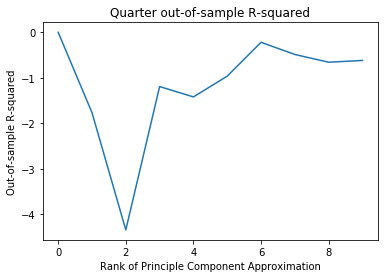

In [74]:
X_quarter = processed_df[2:].set_index('Dates').resample('3M').agg('last')[stock_explanatory_variables].values
r_quarter = processed_df[2:].set_index('Dates').resample('3M').agg('last')['r_SPX'].values
plt.plot([Rsquared_OS(X_quarter,r_quarter,i,66) for i in range(X.shape[1]+1)])
plt.xlabel('Rank of Principle Component Approximation')
plt.ylabel('Out-of-sample R-squared')
plt.title('Quarter out-of-sample R-squared')

### 3.1.2.3  Semi-annual $R_{OS}^2$

For consistency, I utilized 33 semi-annually observations exclusively for fitting the model. Following dataframe shows that 33$^{\text{rd}}$ quarterly observation corresponds to 200$^{\text{th}}$ monthly observation.

In [75]:
processed_df[2:].reset_index().set_index('Dates').resample('6M').agg('last').reset_index()[32:].head()

,Dates,index,log_DP,inflation,Term_Spread,Default_Spread,MA_1_12,MA_2_12,MOMBY_6,MOMBY_12,MOM_9,MOM_12,output_gap,r_SPX,y_bond,r_bond,y_bill,r_bill
32,2007-05-31,194,-3.843610,0.003001,0.2994,0.92,1.0,1.0,-1.0,-1.0,1.0,1.0,0.021707,0.032549,0.048994,0.059055,0.0460,-0.039666
33,2007-11-30,200,-3.788723,0.003083,0.8589,0.96,1.0,1.0,1.0,1.0,1.0,1.0,0.019589,-0.044043,0.039389,-0.119937,0.0308,-0.197917
34,2008-05-31,206,-3.774398,0.002314,2.2153,1.36,0.0,0.0,-1.0,-1.0,0.0,0.0,-0.008239,0.010674,0.040653,0.089075,0.0185,0.312057
35,2008-11-30,212,-3.339371,-0.008598,2.9100,3.09,0.0,0.0,1.0,1.0,0.0,0.0,-0.071761,-0.074849,0.029200,-0.264354,0.0001,-0.977273
36,2009-05-31,218,-3.346824,0.001007,3.3204,2.52,0.0,0.0,-1.0,-1.0,0.0,0.0,-0.137647,0.053081,0.034604,0.109743,0.0014,0.000000


Text(0.5, 1.0, 'Semi-annual out-of-sample R-squared')

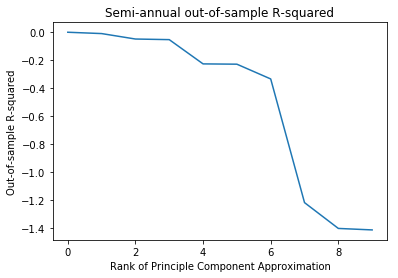

In [76]:
X_semi = processed_df[2:].set_index('Dates').resample('6M').agg('last')[stock_explanatory_variables].values
r_semi = processed_df[2:].set_index('Dates').resample('6M').agg('last')['r_SPX'].values
plt.plot([Rsquared_OS(X_semi,r_semi,i,33) for i in range(X.shape[1]+1)])
plt.xlabel('Rank of Principle Component Approximation')
plt.ylabel('Out-of-sample R-squared')
plt.title('Semi-annual out-of-sample R-squared')

### 3.1.2.4  Annual $R_{OS}^2$

For consistency, I utilized 33 semi-annually observations exclusively for fitting the model. Following dataframe shows that 33$^{\text{rd}}$ quarterly observation corresponds to 200$^{\text{th}}$ monthly observation.

In [77]:
processed_df.reset_index().set_index('Dates').resample('Y').agg(lambda x: x[-2]).reset_index()[15:].head()

,Dates,index,log_DP,inflation,Term_Spread,Default_Spread,MA_1_12,MA_2_12,MOMBY_6,MOMBY_12,MOM_9,MOM_12,output_gap,r_SPX,y_bond,r_bond,y_bill,r_bill
15,2006-12-31,188,-3.814893,-0.004438,-0.4390,0.87,1.0,1.0,1.0,1.0,1.0,1.0,0.006390,0.016467,0.044610,-0.031060,0.0490,-0.010101
16,2007-12-31,200,-3.788723,0.003083,0.8589,0.96,1.0,1.0,1.0,1.0,1.0,1.0,0.019589,-0.044043,0.039389,-0.119937,0.0308,-0.197917
17,2008-12-31,212,-3.339371,-0.008598,2.9100,3.09,0.0,0.0,1.0,1.0,0.0,0.0,-0.071761,-0.074849,0.029200,-0.264354,0.0001,-0.977273
18,2009-12-31,224,-3.617410,0.003002,3.1402,1.13,1.0,1.0,1.0,1.0,1.0,1.0,-0.077893,0.057364,0.032002,-0.054873,0.0006,0.200000
19,2010-12-31,236,-3.755558,0.003482,2.6254,1.05,1.0,1.0,-1.0,-1.0,1.0,1.0,-0.001713,-0.002290,0.027954,0.070378,0.0017,0.416667


/Users/gimdong-geon/python3_cooking/lib/python3.7/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, 'Annual out-of-sample R-squared')

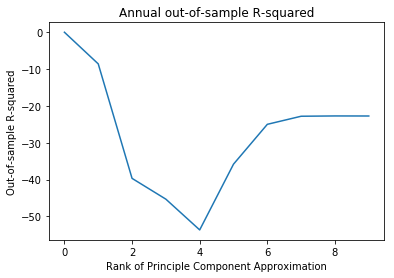

In [78]:
X_annual = (processed_df.set_index('Dates').resample('Y')
            .agg(lambda x: x[-2])[stock_explanatory_variables].values)
r_annual = (processed_df.set_index('Dates').resample('Y')
            .agg(lambda x: x[-2])['r_SPX'].values)
plt.plot([Rsquared_OS(X_annual,r_annual,i,16) for i in range(X.shape[1]+1)])
plt.xlabel('Rank of Principle Component Approximation')
plt.ylabel('Out-of-sample R-squared')
plt.title('Annual out-of-sample R-squared')

### 3.1.3  Clark and Wald (2007) Test Statistics Computation

In [79]:
def CW_test(X,r,dim,OS_start):
    """
    computes Clark and Wald test statistics.
    First computes PCA only using explanatory variables without augmenting the data with a constant = 1.
    For regression result, added a constant to capture the y-intercept. 
    PCA_fit by default adds the constant column. Therefore, I only add the constant column to obtain
    one step ahead forecast using the weights obtained by the PCA_fit

    """
    denom = len(r) - OS_start
    num = []
    for i in range(OS_start,len(r)):
        X_PCA = truncated_PC(X[:i],dim)
        w = PC_fit(X_PCA,r[:i],dim)
        X_PCA_OS = truncated_PC(X[:i+1],dim)
        X_PCA_OS_intercept = np.concatenate((np.ones(X_PCA_OS.shape[0]).reshape(-1,1),X_PCA_OS),axis=1)
        r_hat = np.matmul(X_PCA_OS_intercept[-1],w)
        num += [(r[i]-r[:i].mean())**2 - (r[i] - r_hat)**2  + (r[:i].mean() - r_hat)**2]
    f_bar = np.array(num).mean()
    CW = np.sqrt(denom) * f_bar / np.std(np.array(num) - f_bar,ddof=1)
    return CW

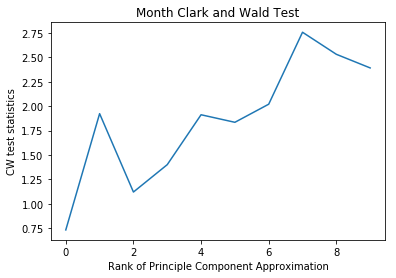

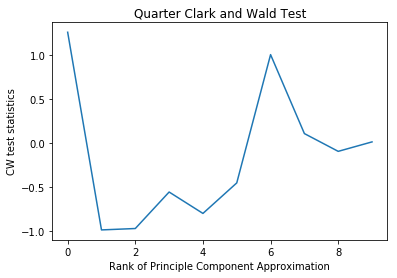

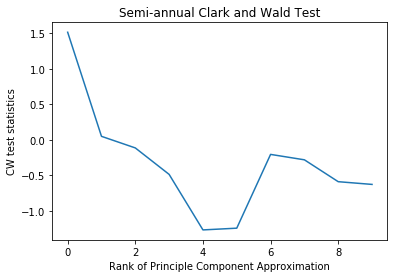

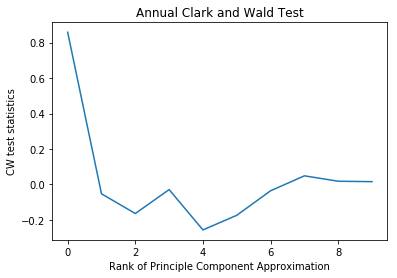

In [80]:
my_dict = {'month':200,'quarter':66,'semi':33,'annual':16}

i=0
for item in my_dict.keys():
    plt.figure(i)
    if item == 'month':
        plt.plot([CW_test(X,r,i,my_dict[item]) for i in range(X.shape[1]+1)])
        plt.xlabel('Rank of Principle Component Approximation')
        plt.ylabel('CW test statistics')
        plt.title('Month Clark and Wald Test')
    else:
        eval(f'plt.plot([CW_test(X_{item},r_{item},i,my_dict[item]) for i in range(X.shape[1]+1)])')
        plt.xlabel('Rank of Principle Component Approximation')
        plt.ylabel('CW test statistics')
        if item == 'semi':
            plt.title(f'{item[0].upper()}{item[1:]}' + '-annual Clark and Wald Test')
        else:
            plt.title(f'{item[0].upper()}{item[1:]} Clark and Wald Test')
    i+=1

### 3.2 Bond Returns

The logic of this section is equivalent to the stock returns. First section deals with principal component, the second section the $R_{OS}^2$ and the third section the Clark Wald test statistics.

In [148]:
bonds_explanatory_variables = ['y_bond','inflation','Term_Spread','Default_Spread',\
                               'output_gap','MOMBY_6','MOMBY_12']
X = processed_df[bonds_explanatory_variables].values
r = processed_df['r_bond'].values

X_quarter = (processed_df[2:].set_index('Dates').resample('3M')
             .agg('last')[bonds_explanatory_variables].values)
y_quarter = (processed_df[2:].set_index('Dates')
             .resample('3M').agg('last')['r_bond'].values)
X_semi = (processed_df[2:].set_index('Dates').resample('6M')
          .agg('last')[bonds_explanatory_variables].values)
y_semi = (processed_df[2:].set_index('Dates')
          .resample('6M').agg('last')['r_bond'].values)
X_annual = (processed_df.set_index('Dates').resample('Y')
        .agg(lambda x: x[-2])[bonds_explanatory_variables].values)
y_annual = (processed_df.set_index('Dates').resample('Y')
        .agg(lambda x: x[-2])['r_bond'].values)


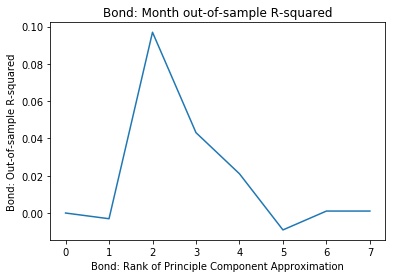

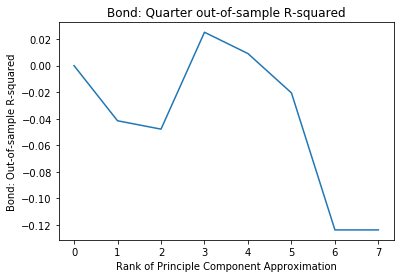

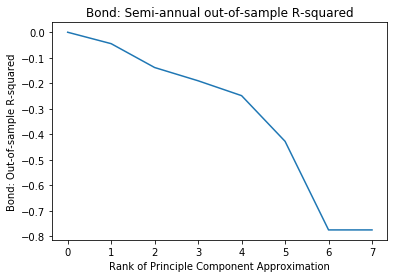

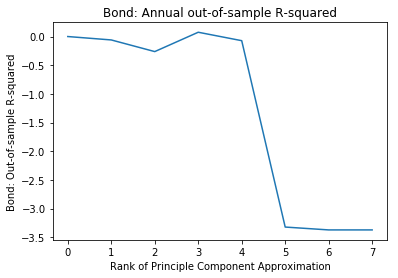

In [149]:
my_dict = {'month':200,'quarter':66,'semi':33,'annual':16}

i=0
for item in my_dict.keys():
    plt.figure(i)
    if item == 'month':
        plt.plot([Rsquared_OS(X,r,i,my_dict[item]) for i in range(X.shape[1]+1)])
        plt.xlabel('Bond: Rank of Principle Component Approximation')
        plt.ylabel('Bond: Out-of-sample R-squared')
        plt.title('Bond: Month out-of-sample R-squared')
    else:
        eval(f'plt.plot([Rsquared_OS(X_{item},r_{item},i,my_dict[item]) for i in range(X.shape[1]+1)])')
        plt.xlabel('Rank of Principle Component Approximation')
        plt.ylabel('Bond: Out-of-sample R-squared')
        if item == 'semi':
            plt.title('Bond: '+f'{item[0].upper()}{item[1:]}' + '-annual out-of-sample R-squared')
        else:
            plt.title('Bond: '+ f'{item[0].upper()}{item[1:]} out-of-sample R-squared')
    i+=1



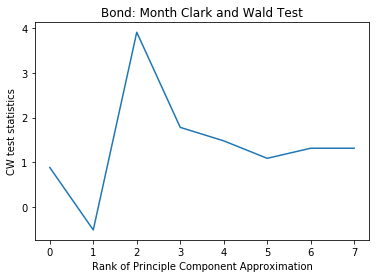

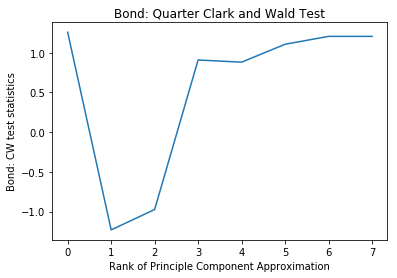

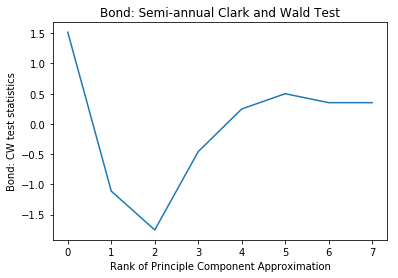

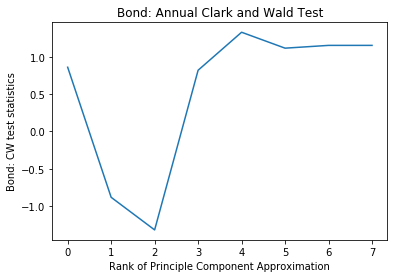

In [151]:
my_dict = {'month':200,'quarter':66,'semi':33,'annual':16}

i=0
for item in my_dict.keys():
    plt.figure(i)
    if item == 'month':
        plt.plot([CW_test(X,r,i,my_dict[item]) for i in range(X.shape[1]+1)])
        plt.xlabel('Rank of Principle Component Approximation')
        plt.ylabel('CW test statistics')
        plt.title('Bond: Month Clark and Wald Test')
    else:
        eval(f'plt.plot([CW_test(X_{item},r_{item},i,my_dict[item]) for i in range(X.shape[1]+1)])')
        plt.xlabel('Rank of Principle Component Approximation')
        plt.ylabel('Bond: CW test statistics')
        if item == 'semi':
            plt.title('Bond: '+f'{item[0].upper()}{item[1:]}' + '-annual Clark and Wald Test')
        else:
            plt.title('Bond: '+ f'{item[0].upper()}{item[1:]} Clark and Wald Test')
    i+=1

### 3.3 Bill Returns

The result is not as expected for bill returns. I suspect that the compound return data provided by the Factset is not accurate. For visualization of the data, Please refer to the next cell. The data shows the 1-month return. However, the maximum return was 10.0 and minimum value was -9. Clearly, return of -9 does not make sense. As I have checked the function I used to compute the return, I should find another source to obtain the return data. However, I do not currently know where I can retrieve the data.


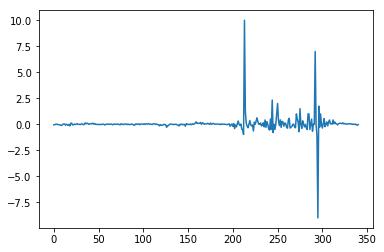

In [167]:
plt.plot( processed_df['r_bill'].values)

In [168]:
processed_df['r_bill'].values.min()

-8.999999999997765

In [169]:
X = processed_df['y_bill'].values.reshape(-1,1)
r = processed_df['r_bill'].values

X_quarter = (processed_df[2:].set_index('Dates').resample('3M')
             .agg('last')[['y_bill']].values)
y_quarter = (processed_df[2:].set_index('Dates')
             .resample('3M').agg('last')['r_bill'].values)
X_semi = (processed_df[2:].set_index('Dates').resample('6M')
          .agg('last')[['y_bill']].values)
y_semi = (processed_df[2:].set_index('Dates')
          .resample('6M').agg('last')['r_bill'].values)
X_annual = (processed_df.set_index('Dates').resample('Y')
        .agg(lambda x: x[-2])[['y_bill']].values)
y_annual = (processed_df.set_index('Dates').resample('Y')
        .agg(lambda x: x[-2])['r_bill'].values)

In [170]:
my_dict = {'month':200,'quarter':66,'semi':33,'annual':16}

i=0
for item in my_dict.keys():
    if item=='month':
        print('Month Rsquared_OS: ', Rsquared_OS(X,r,1,my_dict[item]))
    else:
        eval( f'print(item," Rsquared_OS: ",Rsquared_OS(X_{item},r_{item},1,my_dict[item]))')


Month Rsquared_OS:  -0.00963719144583619
quarter  Rsquared_OS:  -0.05757419481227144
semi  Rsquared_OS:  -0.16981965806816768
annual  Rsquared_OS:  -0.4422955358190517


In [171]:
my_dict = {'month':200,'quarter':66,'semi':33,'annual':16}

i=0
for item in my_dict.keys():
    if item=='month':
        print('Month Rsquared_OS: ', CW_test(X,r,1,my_dict[item]))
    else:
        eval( f'print(item," Rsquared_OS: ",CW_test(X_{item},r_{item},1,my_dict[item]))')


Month Rsquared_OS:  -0.4211238819678403
quarter  Rsquared_OS:  -2.285135505687965
semi  Rsquared_OS:  -1.353549076476365
annual  Rsquared_OS:  -1.1960589001920952


## 4. Portfolio Performance Evaluation

Choice of the number of Principal Components for Month:
Stock: 7, Bond: 2

## 4.1 Return Estimate

In [189]:
r_actual = processed_df[['r_SPX','r_bond','r_bill']].values

In [264]:
r_hat_SPX = []
for i in range(r_actual.shape[0]):
    X_stock_PCA = truncated_PC(processed_df[stock_explanatory_variables][:i].values,7)
    w_stock = PC_fit(X_stock_PCA,r_actual[:i,0],7)
    x_stock_PCA_new = np.concatenate((np.ones(1),truncated_PC(processed_df[stock_explanatory_variables][:i+1].values,7)[-1,:]))
    r_hat_SPX+=[np.dot(x_stock_PCA_new,w_stock)]

No handles with labels found to put in legend.


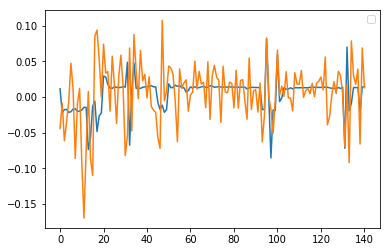

In [265]:
plt.plot(r_hat_SPX[200:])
plt.plot(r_actual[200:,0])
plt.legend()

In [377]:
r_hat_bond = []
for i in range(r_actual.shape[0]):
    X_bond_PCA = truncated_PC(processed_df[bonds_explanatory_variables][:i].values,2)
    w_bond = PC_fit(X_bond_PCA,r_actual[:i,1],2)
    x_bond_PCA_new = np.concatenate((np.ones(1),truncated_PC(processed_df[bonds_explanatory_variables][:i+1].values,2)[-1,:]))
    r_hat_bond+=[np.dot(x_bond_PCA_new,w_bond)]

No handles with labels found to put in legend.


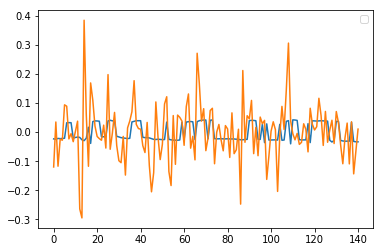

In [378]:
plt.plot(r_hat_bond[200:])
plt.plot(r_actual[200:,1])
plt.legend()

In [354]:
r_hat_bill = []
X_bill = np.concatenate((np.ones(r_actual.shape[0]).reshape(-1,1),
                         processed_df['y_bill'].values.reshape(-1,1)),axis=1)
for i in range(r_actual.shape[0]):
    w_bill = np.matmul(
                    np.matmul(
                        np.linalg.inv(1e-6*np.eye(2) + np.matmul(
                            X_bill[:i-1,:].transpose(),X_bill[:i-1,:])),
                            X_bill[:i-1,:].transpose()),
                        r_actual[:i-1,2])
    r_hat_bill+=[np.dot(X_bill[i-1,:],w_bill)]
    
    
    

No handles with labels found to put in legend.


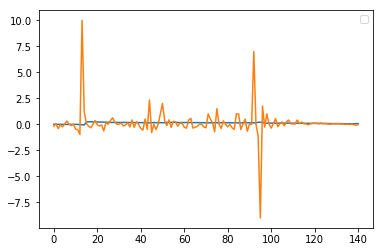

In [353]:
plt.plot(r_hat_bill[200:])
plt.plot(r_actual[200:,2])
plt.legend()

In [467]:
r_hat = pd.DataFrame(r_hat_SPX,columns = ['r_hat_SPX'])
r_hat['r_hat_bond'] = pd.Series(r_hat_bond)
r_hat['r_hat_bill'] = pd.Series(r_hat_bill)
r_hat = r_hat.astype(float)

## 4.2 EWMA Covariance Estimate

I referred the formula of Exponentially Weighted Moving Average from Table 5.1 of Riskmetrics - technical document. It is as following:
$$Cov(r^i, r^j)= (1-\lambda)\sum_{t=0}^{T-1}\lambda^t (r_{t}^{i}-\overline{r}_{t}^{i})(r_{t}^{j}-\overline{r}_{t}^{j}) \quad i,j \in{\{stock, bond, bill\}}$$
The way I compute this amount is:
$$ X =\begin{pmatrix}
r^{stock}_0 -\overline{r}^{stock}& r^{bond}_0  -\overline{r}^{bond}& r^{bill}_0 -\overline{r}^{bill}\\ 
r^{stock}_1 -\overline{r}^{stock}&  r^{bond}_1 -\overline{r}^{bond}& r^{bill}_1 -\overline{r}^{bill}\\ 
r^{stock}_3 -\overline{r}^{stock}&  r^{bond}_2 -\overline{r}^{bond}& r^{bill}_2 -\overline{r}^{bill}
\end{pmatrix} \\
\Rightarrow
\tilde{X}=\sqrt{1-\lambda}\bigl(\begin{smallmatrix}
1 & 0 & 0\\ 
 0&  \lambda^{0.5}& 0\\ 
 0&  0& \lambda
\end{smallmatrix}\bigr)X =\sqrt{1-\lambda} \begin{pmatrix}
r^{stock}_0 -\overline{r}^{stock}& r^{bond}_0  -\overline{r}^{bond}& r^{bill}_0 -\overline{r}^{bill}\\ 
\lambda^{0.5}(r^{stock}_1 -\overline{r}^{stock})&  \lambda^{0.5}(r^{bond}_1 -\overline{r}^{bond})&\lambda^{0.5}( r^{bill}_1 -\overline{r}^{bill})\\ 
\lambda(r^{stock}_2 -\overline{r}^{stock})&  \lambda(r^{bond}_2 -\overline{r}^{bond})&\lambda( r^{bill}_2 -\overline{r}^{bill})
\end{pmatrix}= (\tilde{r}^{stock},\tilde{r}^{bond},\tilde{r}^{bill} )
\\
$$

$$\Rightarrow
\tilde{X}^T\tilde{X} = \begin{pmatrix}
 (\tilde{r}^{stock})^T\tilde{r}^{stock}& (\tilde{r}^{stock})^T\tilde{r}^{bond} &(\tilde{r}^{stock})^T\tilde{r}^{bill} \\ 
 (\tilde{r}^{bond})^T\tilde{r}^{stock}&  (\tilde{r}^{bond})^T\tilde{r}^{bond}& (\tilde{r}^{bond})^T\tilde{r}^{bill}\\ 
 (\tilde{r}^{bill})^T\tilde{r}^{stock}&  (\tilde{r}^{bill})^T\tilde{r}^{bond}& (\tilde{r}^{bill})^T\tilde{r}^{bill}
\end{pmatrix} = \begin{pmatrix}
Cov(r^{stock},r^{stock}) &  Cov(r^{stock},r^{bond})&Cov(r^{stock},r^{bill}) \\ 
Cov(r^{bond},r^{stock}) & Cov(r^{bond},r^{ond}) & Cov(r^{bond},r^{bill})\\ 
Cov(r^{bill},r^{stock}) & Cov(r^{bill},r^{bond}) & Cov(r^{bill},r^{bill})
\end{pmatrix}
$$

In [468]:
def EWMA(t):
    decay = 0.94
    A = np.matmul(np.diag([np.sqrt((1-decay)*decay**i) 
                           for i in range(t+1)]),r_actual[:t+1])
    return np.matmul(A.T,A)

In [469]:
EWMA(200)

array([[ 0.00114833, -0.00062392, -0.00050918],
       [-0.00062392,  0.00154445,  0.00122935],
       [-0.00050918,  0.00122935,  0.00318574]])

## 4.3 Black Litterman $\mu$ and $\Sigma$

### 4.3.1 Covariance Matrix of Active Views

$$\omega_{j} = \left( \frac{1-c_{j}}{c_{j}} \right)p_{j}\hat{\Sigma}_{t:t+h}p_{j}^{T}\quad \text{for} \space j = \text{stock, bond, or bill}$$
where $p_{stock}, p_{bond}, p_{bill}$ are first, second and third rows of $P = I_{3}$. And, $c_{stock} = 0.25, c_{bond} = 0.50, c_{bill} = 0.75$. Note that larger the c is, less relevant is the investor view and when c equals 1 then investor view is considered majestic. The rationale for the choice of parameter is that if regression result is credit-worthy (characterized by high $R^2_{OS}$) then do not utilize information about views.

I slightly modify the weights `c` because of poor quality of bond/bill returns data I obtained.

In [470]:
omega_stock = [(1/0.75 -1)*EWMA(t)[0,0] for t in range(r_actual.shape[0])]
omega_bond  = [(1/0.5 -1)*EWMA(t)[1,1] for t in range(r_actual.shape[0])]
omega_bill  = [(1/0.25 -1)*EWMA(t)[2,2] for t in range(r_actual.shape[0])]

In [471]:
Omega = []
for i in range(len(omega_stock)):
    Omega += [np.diag([omega_stock[i],omega_bond[i],omega_bill[i]])]

### 4.3.2 $\mu_{BL}$ And $\Sigma_{BL}$

$$\mu_{BL} = \mu + \hat{\Sigma} P^T(P\hat{\Sigma}P^T+\Omega)^{-1}(V-P \mu) $$
$$ \Sigma_{BL} = \hat{\Sigma} - \hat{\Sigma}P^T(P\hat{\Sigma}P^T+\Omega)^{-1}P\hat{\Sigma}$$

Da Silva(2009) claims that Black-Litterman was derived under the mean-variance portfolio optimization rather than optimizing the common active management performance measure, the information ratio. And, this resulted in a bias that could lead to unintentional trades.

The authors' remedy for this issue pertains to the practice of obtaining implied equilibrium excess returns through $\mu = \gamma \Sigma \omega_B$ where $\gamma$ is a risk-aversion coefficient. The author asserts to set $\mu = 0$. And, $\hat{r}$ is considered to be the active views $V$ and $P$ is assumed to be $I_3$.
In summary,
$$\mu_{BL} = \hat{\Sigma}(\hat{\Sigma}+\Omega)^{-1}\hat{r} $$
$$ \Sigma_{BL} = \hat{\Sigma} - \hat{\Sigma}(\hat{\Sigma}+\Omega)^{-1}\hat{\Sigma}$$

In [478]:
mu_BL = []
Sigma_BL = []
for i in range(len(r_actual)):
    mu_BL+=[np.dot(np.matmul(EWMA(i),np.linalg.inv(1e-6 + EWMA(i) + Omega[i])),r_hat.values[i] )]
    Sigma_BL+=[EWMA(i)-np.matmul(np.matmul(EWMA(i),np.linalg.inv(1e-6 +EWMA(i)+Omega[i])),EWMA(i))]

### 4.3.3 Black-Litterman Return Expectation and Variance

$log(r)|view \sim N(\mu_{BL},\Sigma_{BL}) \\ \Rightarrow E[P^i_{t}] = P^i_{0}exp\left(\mu_{BL,i} + \frac{1}{2} \Sigma_{BL,(i,i)}\right) \quad \text{where} \quad i\in{\{stock,bond,bill\}}
 \\ \quad Cov[P^i_{t},P^j_{t}] =P^i_{0}P^i_{0}exp\left(\mu_{BL,i}+\mu_{BL,j}\right)exp\left(\frac{1}{2}\left(\Sigma_{BL,(ii)} +   \Sigma_{BL,(jj)}\right)\right)\bigodot\left(exp\left(\Sigma_{BL,(ij)}-1\right)\right) \quad \text{where}  \quad  i,j\in{\{stock,bond,bill\}}        $

In [676]:
m=[]
S=[]
for i in range(len(r_actual)):
    m += [np.exp(mu_BL[i]+0.5*np.diag(Sigma_BL[i])).reshape(-1,1)  - 1]
    S += [np.multiply(np.matmul(np.exp(mu_BL[i]+0.5*np.diag(Sigma_BL[i])).reshape(-1,1),
          np.exp(mu_BL[i]+0.5*np.diag(Sigma_BL[i])).reshape(-1,1).T),np.exp(Sigma_BL[i]) - 1)]

### 4.3.4 DAA Portfolio Optimization

Optimization problem is:


\begin{aligned}
\min_{w} \quad & -\left ( w-w_{bench} \right )^Tm\\
\textrm{s.t.} \quad & \left \| R\left ( w-w_{bench} \right ) \right \|_2 \leq (h/12)TE^2\\
 & w^T1_3 =1    \\
 & -w  \leq -w_{LB}
\end{aligned}

where $R$ is the Cholesky Decomposition of $S$
This is equivalent to:

\begin{aligned}
\min_{u} \quad & -u^Tm\\
\textrm{s.t.} \quad
 & u^T1_3 \leq -0.5    \\
 & -u^T1_3 \leq 0.5 \\
 & -u  \leq -w_{LB} + w_{bench} \\
 & \left \| Ru \right \|_2 \leq 0.02^2/12
\end{aligned}

In [636]:
def cholesky(A):
    """
    computes left cholesky matrix. Advantage of this matrix over np.linalg.cholesky
    is that first few observation of S matrix is not positive definite which creates
    an error message.
    """
    L = np.eye(3)
    L[1:,0]=-S[5][1:,0]/S[5][0,0]
    tmp = np.matmul(L,S[5])
    L2 = np.eye(3)
    L2[2,1] = -tmp[2,1]/tmp[1,1]
    diag = np.sqrt(np.matmul(np.matmul(np.matmul(L2,tmp),L.T),L2.T))
    Linv=np.eye(3)
    Linv[1:,0] = -L[1:,0]/L[0,0]
    L2inv=np.eye(3)
    L2inv[2,1] = -L2[2,1]/L2[1,1]
    Left = np.matmul(np.matmul(Linv,L2inv),diag)
    return Left

In [674]:
# Write Gurobi Script below: Modify the sample.

In [698]:
R = cholesky(S[10]).T
R

array([[ 0.0083659 , -0.00125391, -0.00166553],
       [ 0.        ,  0.00749668,  0.00284972],
       [ 0.        ,  0.        ,  0.01401753]])

In [706]:
from gurobipy import *

# Create a new model
model = Model("qcp")

# Create variables
u1 = model.addVar(name="u1")
u2 = model.addVar(name="u2")
u3 = model.addVar(name="u3")

# Set objective: x
obj = m[10][0][0]*u1 + m[10][1][0]*u2 + m[10][2][0]*u3 
model.setObjective(obj, GRB.MAXIMIZE)

# Add constraint: u1 + u2 + u3  =< -0.5
# model.addConstr(u1 + u2 + u3 == -0.5, "c0")

# model.addConstr( -u1  <= w_bench[0] -w_LB[0], "c2")

# model.addConstr( -u2  <= w_bench[1] -w_LB[1], "c3")

# model.addConstr( -u3  <= w_bench[2] -w_LB[2], "c4")

# Add second-order cone: 
model.addConstr( (R[0,0]*u1 + R[0,1]*u2 + R[0,2]*u3)*(R[0,0]*u1 + R[0,1]*u2 + R[0,2]*u3)
                + ( R[1,1]*u2 + R[1,2]*u3)*( R[1,1]*u2 + R[1,2]*u3)
                + (R[2,2]*u3)*(R[2,2]*u3)
                <= (TE**2 *(1/12))*(TE**2 *(1/12)), "qc0")
model.optimize()

for v in model.getVars():
    print('%s %g' % (v.varName, v.x))

print('Obj: %g' % obj.getValue())

Optimize a model with 0 rows, 3 columns and 0 nonzeros
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  QMatrix range    [2e-05, 2e-04]
  Objective range  [5e-01, 8e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
  QRHS range       [1e-09, 1e-09]
Presolve time: 0.01s
Presolved: 4 rows, 7 columns, 10 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 6.000e+00
 Factor NZ  : 1.000e+01
 Factor Ops : 3.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   7.34674688e+00 -0.00000000e+00  1.11e-01 1.30e+02  7.27e+00     0s
   1   3.77674443e+00  6.25537811e-03  4.71e-02 1.43e-04  1.45e+00     0s
   2   5.75272712e-03  6.25222234e-03  4.41e-05 1.58e-10  1.91e-03     0s
   3   2.54708533e-03  4.28666559e-03  2.95e-11 1.42e-13